![](https://contestfiles.storage.yandexcloud.net/companies/86a6a31f4467a95b9020dad414fbf7e0/contests/898/ZeWzwbik_1684220572.webp)

# Text Generation Detection: GPT or Human 
#by Codenrock

## Как ты думаешь, этот текст написал человек или искусственный интеллект? 

✒️ Прими участие в ML-соревновании от Codenrock, которое пройдёт с 23 мая по 7 июня.

Основная задача Text Generation Detection: GPT or Human:  
Необходимо разработать модель, которая сможет отличать тексты, написанные искусственным интеллектом от текстов, написанных человеком. Участникам будут предоставлены наборы данных, содержащие тексты обеих категорий. Модель должна классифицировать каждый текст на две категории с высокой точностью. Для оценки точности классификации будет использоваться метрика F1. 

☝️ Для чего проводится соревнование Text Generation Detection: GPT or Human?  
Важно различать тексты, созданные искусственным интеллектом и написанные людьми, поскольку фальсификация текстов становится все более распространенной проблемой. Сегодня ИИ может генерировать фэйковые новости, обманывать системы безопасности, искажать информацию в Интернете. Поэтому задача соревнования является актуальной и важной для решения многих проблем, связанных с цифровой безопасностью.

In [2]:
!python -V


Python 3.10.12


In [3]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")
tf.test.gpu_device_name()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

'/device:GPU:0'

In [6]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [7]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6513212827535251528
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10067378176
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9208683456779728418
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

In [ ]:
!pip install sentence_transformers

In [ ]:
!pip install catboost 

In [ ]:
!pip install pyspellchecker lightgbm

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
from catboost import CatBoostClassifier
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from nltk.tokenize import sent_tokenize, word_tokenize
from spellchecker import SpellChecker
import lightgbm as lgb
import numpy as np
# from xgboost import XGBClassifier
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
# %matplotlib ipympl
import matplotlib.pyplot as plt


nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

Загружаем данные:

In [13]:
df = pd.read_csv('train.csv')
df.head(6)

,q_title,q_id,label,ans_text,line_id
0,"Какие комплектующие должны быть в компьютере, ...",fff6c529-c037-47c8-b33b-873397243fbd,hu_answer,"Да ничего особенного. :)\nКорпус должен быть, ...",735ba0c5-e6b2-461a-bf5d-b7cb67d42299
1,"Какие комплектующие должны быть в компьютере, ...",fff6c529-c037-47c8-b33b-873397243fbd,ai_answer,Здравствуйте! Спасибо за интересный вопрос. Дл...,f5eb55c6-2785-4ddc-8f97-30021fd75d68
2,Loading a Reusable UITableViewCell from a Nib,fff28c1f-9331-4467-b6f4-143d127a02a0,ai_answer,"To load a reusable UITableViewCell from a Nib,...",bfd3d85e-6981-423d-a138-7580530a1f85
3,Loading a Reusable UITableViewCell from a Nib,fff28c1f-9331-4467-b6f4-143d127a02a0,hu_answer,"Actually, since you are building the cell in I...",b823bb82-4b05-41ec-b226-7bd0aef29711
4,How can I change UIButton title color?,ffeccbf1-eff2-42b2-a472-f2a8c70b7dbd,hu_answer,You can use -[UIButton setTitleColor:forState:...,4816a574-6bbf-4658-b37b-39d05c29dfca
5,Если обо мне слишком много знает корпорация из...,ffb99bf4-6a47-4e47-b8bf-6c416eeb0507,ai_answer,"Конечно, вы можете попросить корпорацию удалит...",ed2caf58-5acf-4d97-8fa3-cadc53bdc198


# Гипотеза с повторением вопроса в ответе ИИ

Гипотеза: Ответ на вопрос ИИ начинает с перефразирования вопроса, то есть вопрос и первое или второе предложения будут очень похожи. "Похожесть" анализируем с помощью косинусного расстояния между эмбеддингами.

In [14]:
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1')

def calculate_cos_sim(sentences1,sentences2):
    """Calculate Cosine similarity between sentences"""

    embeddings1 = model.encode(sentences1, convert_to_tensor=True)
    embeddings2 = model.encode(sentences2, convert_to_tensor=True)
    cosine_scores = util.cos_sim(embeddings1, embeddings2)

    return cosine_scores[0][0]

Определяем маску для ответов ИИ:

In [6]:
ai_mask = df["label"] == "ai_answer"

Выделяем первое и второе предложение в ответе:

In [7]:
df["first_sentence"] = df["ans_text"].apply(lambda x: x.split('.')[0])
df["second_sentence"] = df["ans_text"].apply(lambda x: x.split('.')[1] if "." in x else "")

Считаем косинусное расстояние между вопросом и ответом:

In [8]:
df["first_sentence_cos_sim"] = df.apply(lambda x: calculate_cos_sim(x["q_title"], x["first_sentence"]), axis=1)
df["second_sentence_cos_sim"] = df.apply(lambda x: calculate_cos_sim(x["q_title"], x["second_sentence"]), axis=1)

Сравнение статистик:

In [ ]:
df[ai_mask]["first_sentence_cos_sim"].astype(float).describe()

count    2425.000000
mean        0.593416
std         0.238656
min        -0.092043
25%         0.505548
50%         0.658030
75%         0.764499
max         0.944500
Name: first_sentence_cos_sim, dtype: float64

In [ ]:
df[~ai_mask]["first_sentence_cos_sim"].astype(float).describe()

count    2394.000000
mean        0.307732
std         0.199946
min        -0.130249
25%         0.143848
50%         0.300723
75%         0.456384
max         0.901919
Name: first_sentence_cos_sim, dtype: float64

Видим, что, в среднем, первое предложение в ответе ИИ больше похоже на вопрос, чем ответы, которые давал человек.

Гипотеза верна.

# Гипотеза: слова-паразиты

Гипотеза: в ответах людей больше слов-паразитов

In [ ]:
parasite_words = [
    "like", "you know", "um", "uh", "basically", "literally", "actually", "kind of", "sort of",
    "so", "well", "I mean", "you see", "okay", "right", "totally", "seriously", "definitely",
    "absolutely", "obviously", "apparently", "somehow", "anyway", "anyhow", "anyhow", "whatever",
    "whenever", "wherever", "however", "I guess", "I suppose", "to be honest", "to tell you the truth",
    "in a way", "by the way", "like I said", "as I was saying", "for example", "in other words",
    "that being said", "on the other hand", "вобщем", "типа", "короче", "ну", "это", "так сказать", "в общем-то", "вообще", "знаешь", "такое",
    "как бы", "однако", "понимаешь", "слушай", "так", "наверное", "просто", "то есть", "так себе",
    "ну типа", "короче говоря", "собственно", "в смысле", "честно говоря", "как бы то ни было",
    "в принципе", "как-то", "вот", "в общем", "всё-таки", "смысл", "видишь ли", "как ни странно",
    "ну вот", "что-то", "как раз", "извини", "что уж", "в общем-то", "допустим", "словно", "значит"]

In [ ]:
def count_parasite_words(text):
    """Count parasite words in text."""
    count = 0
    words = re.findall(r'\b\w+\b', text)  # Разбиваем текст на отдельные слова

    for word in words:
        if word.lower() in parasite_words:
            count += 1

    return count

df['parasite_count'] = df['ans_text'].apply(count_parasite_words)

Сравнение статистик:

In [ ]:
df[ai_mask]['parasite_count'].value_counts()

In [ ]:
df[~ai_mask]['parasite_count'].value_counts()

Гипотеза верна. В ответах людей большее количество слов-паразитов

# Гипотеза: определение стилевых признаков

Гипотеза: стиль ответов ИИ отличается от стиля ответов людей. Для определения стиля проанализируем какие части речи и как часто встречаются в ответах.

Считаем количество частей речи в ответах:

In [ ]:
tags = {
    "verbs":"V",        # глаголы
    "nouns":"N",        # существительные
    "adjective":"J",    # прилагательные
    "adverb":"R"        # наречия
}


def count_tags(text, tag_name):
    """Count tag in text"""
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    tags_name_count = len([word for word, pos in tagged if pos.startswith(tag_name)])
    
    return tags_name_count

In [ ]:
for tag, tag_name in tags.items():
    df[tag + '_count'] = df['ans_text'].apply(lambda x: count_tags(x, tag_name))

При анализе статистик, видим, что стили ИИ и человека отличаются для глаголов, существительных и прилагательных.

# Гипотеза: разное количество слов и разное количество предложений в текстах ответов.

Размер ответа ИИ физически ограничен.

In [ ]:
def count_words_in_text(text):
    text = text.strip()
    sentences = sent_tokenize(text)
    total_words = sum([len(word) for word in sentences])
    return total_words


def count_sentence_in_text(text):
    text = text.strip()
    sentences = sent_tokenize(text)
    return len(sentences)

df["sentence_count"] = df["ans_text"].apply(count_sentence_in_text)
df["words_count"] = df["ans_text"].apply(count_words_in_text)

### Подсчет слов через REGEX

In [ ]:
df["is_human"] = df["words_count"].apply(lambda x: 0.95 if x>2000 else 0.05)

In [ ]:
df["words_count"][ai_mask].describe()

count    2425.000000
mean      651.451546
std       297.899782
min        39.000000
25%       438.000000
50%       570.000000
75%       816.000000
max      2512.000000
Name: words_count, dtype: float64

<Axes: ylabel='Frequency'>

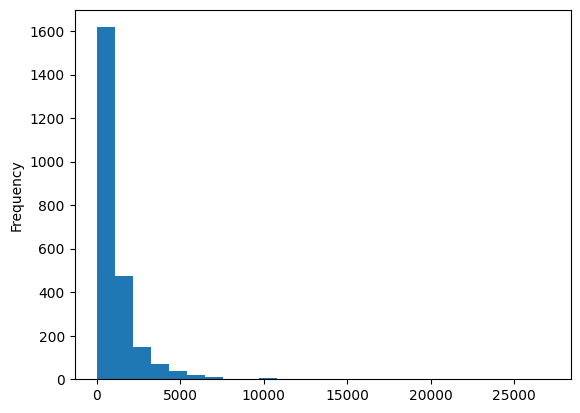

In [ ]:
df["words_count"][~ai_mask].plot.hist(bins=25)

In [ ]:
words_rgx = re.compile(r'\b\w+\b')  # Разбиваем текст на отдельные слова

def count_words(text):
    words = words_rgx.findall(text)
    return len(words)


In [ ]:
df['count_words_rgx'] = df['ans_text'].apply(count_words)
df["is_human"] = df["count_words_rgx"].apply(lambda x: 0.95 if x>387 else 0.05)
df[['count_words_rgx',"words_count"]].head(5)

In [ ]:
max_words_condition = df["count_words_rgx"] > 387
pd.concat(
    [df["count_words_rgx"][ai_mask].describe(),
    df["count_words_rgx"][~ai_mask][~max_words_condition].describe()],
    axis=1
)

,count_words_rgx,count_words_rgx
count,2425.000000,2163.000000
mean,105.065567,123.161350
std,48.541494,89.050191
min,5.000000,3.000000
25%,70.000000,52.000000
50%,91.000000,98.000000
75%,132.000000,171.500000
max,387.000000,387.000000


In [ ]:
max_words_condition.sum()

231

### Видно, что количество слов в ответе у ИИ не больше 378. В среднем, слов в ответе у человека больше.

# Гипотеза: разное количество грамматических ошибок в ответах

In [ ]:
!pip install pyspellchecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 87.9 MB/s eta 0:00:00


In [ ]:
ru_spell = SpellChecker(language='ru')
en_spell = SpellChecker(language='en')

ru_rgx = re.compile(r'[^а-яА-ЯёЁ ]')
en_rgx = re.compile(r'[^a-zA-Z ]')

def define_mistakes_count(text):
    """Count sum of 'ru' and 'en' mistakes."""
    ru_text = ru_rgx.sub('', text)
    ru_mistakes = ru_spell.unknown(ru_text.split())

    en_text = en_rgx.sub('', text)
    en_mistakes = en_spell.unknown(en_text.split())

    return len(ru_mistakes) + len(en_mistakes)


df["mistakes_count"] = df["ans_text"].apply(define_mistakes_count)
df["is_human_mistakes"] = df["mistakes_count"].apply(lambda x: 0.95 if x>60 else 0.05)

Количество грамматических ошибок в ответах у ИИ меньше 60.

# Гипотеза: анализ тональности текста

Гипотеза: разное количество положительно, отрицательно или нейтрально окрашенных ответов на вопросы. 

In [ ]:
sid = SentimentIntensityAnalyzer()

df['sentiment_scores'] = df["ans_text"].apply(lambda x: sid.polarity_scores(x))
df['neg'] = df['sentiment_scores'].apply(lambda x: x['neg'])
df['neu'] = df['sentiment_scores'].apply(lambda x: x['neu'])
df['pos'] = df['sentiment_scores'].apply(lambda x: x['pos'])
df['compound'] = df['sentiment_scores'].apply(lambda x: x['compound'])

# Гипотеза: подавать на вход модели вопрос, ответ и фичи

Гипотеза: подавать на вход модели все данные: вопросы, ответы и фичи. Эта мысль оказалась не такой очевидной.

In [ ]:
ans_train = df["ans_text"].values
qu_train = df["q_title"].values

embeddings_ans = model.encode(ans_train)
embeddings_qu = model.encode(qu_train)

# Проверка по метрикам

In [ ]:
def train_and_make_predictions(X_train, y_train, X_test):
    """Train Classifier and predicted X_test."""
    # Можно использовать другой классификатор, например:
    # clf = CatBoostClassifier(verbose=False, iterations=1000, learning_rate=0.02)
    clf = lgb.LGBMClassifier(n_estimators=1600, learning_rate=0.15)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred


### f1 score

In [ ]:
class_cols = [
    'first_sentence_cos_sim', 
    'second_sentence_cos_sim', 
    'parasite_count',
    'verbs_count', 'nouns_count', 'adjective_count', 'adverb_count',
    "sentence_count", 
    "words_count", 
    "is_human",
    "mistakes_count", 
    "is_human_mistakes",
    "count_words_rgx",
    'sentiment_scores,
    'neg',
    'neu',
    'pos',
    'compound',
]

In [ ]:
X = np.concatenate((embeddings_ans, embeddings_qu, df[class_cols].astype(float)), axis=1)
y = df["label"].map({'ai_answer': 1, 'hu_answer': 0}).values
X.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred = train_and_make_predictions(X_train, y_train, X_test)
f1_score(y_test, y_pred)

# Итог

Результат на лидерборде `0.95`, `место 13` из 26. (Первое место - `0.99`)

`Впечатления` от участия `очень положительные`: нагенерировали много фич. Почти каждая новая фича давала 1% к f1-score!

Поздно подключились к хакатону, не хватило времени придумать и опробовать фичи со знаками пунктуации: количество знаков препинания, количество скобок, количество запятых, количество восклицательных знаков, комментарии в коде и т.д.

З.Ы.: В последние два дня не могли проверить свои результаты, потому что не собиралась сборка на стороне Codenrock.

З.Ы.2: Модель DeepPavlop показала лучший скор 0.97, но проверить мы её не смогли.

З.Ы.3: TF-IDF vectorizer показал тоже хороший скор, но проверить модель так же смогли.

# Далее описаны неудачные гипотезы или гипотезы, которые не удалось проверить.

# TFIDFtokenizer

Гипотеза, которую не смогли проверить.
 
Часто для классификации используют модифицированную модель мешка слов `TfidfVectorizer()`.

In [ ]:
df.columns

Index(['q_title', 'q_id', 'label', 'ans_text', 'line_id', 'parasite_count',
       'verbs_count', 'nouns_count', 'adjective_count', 'adverb_count',
       'sentence_count', 'words_count', 'mistakes_count', 'is_human_mistakes'],
      dtype='object')

In [ ]:
class_cols_tf = [
    "ans_text",
    'first_sentence_cos_sim', 
    'second_sentence_cos_sim',
    'parasite_count',
    'verbs_count', 'nouns_count', 'adjective_count', 'adverb_count',
    "sentence_count", 
    "words_count", 
    # "is_human",
    "mistakes_count", 
    "is_human_mistakes",
    # "count_words_rgx"
]

In [ ]:
# feat_X = df[class_cols].astype(float).to_numpy()
X = df[class_cols_tf]
X.shape
y = df["label"].map({'ai_answer': 1, 'hu_answer': 0}).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_X_train = vectorizer.fit_transform(X_train["ans_text"])
tfidf_X_test = vectorizer.transform(X_test["ans_text"])   # очень важно на тесте использовать tranform!

In [ ]:
X_tr = X_train[class_cols_tf[1:]].astype(float).to_numpy()
X_tr = np.concatenate([tfidf_X_train.toarray(), X_tr], axis=1)

X_ts = X_test[class_cols_tf[1:]].astype(float).to_numpy()
X_ts = np.concatenate([tfidf_X_test.toarray(), X_ts], axis=1)


In [ ]:
X_tr.shape, X_ts.shape

((4337, 56316), (482, 56316))

In [ ]:
y_pred = train_and_make_predictions(X_tr, y_train, X_ts)
f1_score(y_test, y_pred)

0.9523809523809523

Получился хороший результат, при этом использовали ещё не все фичи. К сожалению, проверить эту гипотезу не смогли из-за того, что не собиралась сборка на Gitlab.

# Модели. 

In [ ]:
# model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2') #0.9422
# model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')0,92
# model = SentenceTransformer('symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli')0,911
# model = SentenceTransformer('clips/mfaq')0.92
# model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2') 
# model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
# model = SentenceTransformer('bert-base-uncased')
# model = SentenceTransformer('DeepPavlov/bert-base-cased-conversational') лучший результат

# Нормализация данных или шкалирование.

Было предположение, что сделав шкалирование, размерность фичей станет одинаковой и, следовательно, их влияние на предсказание будут одинаковыми.

In [ ]:
X2 = X.copy()

In [ ]:
X = X2.copy()

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

cols_to_scale = [
    'parasite_count',
    'verbs_count', 'nouns_count', 'adjective_count', 'adverb_count',
    "sentence_count", 
    "words_count", 
    "is_human",
    "mistakes_count", 
    "is_human_mistakes",
    "count_words_rgx"
]

# Были опробованы и другие scalers: StandardScaler, MinMaxScaler
scaler = RobustScaler()

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

К сожалению, результатов это преобразование не дало, потому что Классификаторы CatBoostClassifier и другие, под капотом, сами преобразуют данные наилучшим образом.

# Keras

Было предположение, что НС справится лучше с задачей.

In [ ]:
df.columns

Index(['q_title', 'q_id', 'label', 'ans_text', 'line_id'], dtype='object')

In [ ]:
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sentence_transformers import SentenceTransformer


ans_train = df["ans_text"].values
q_train = df["q_title"].values
# ans_test = X_test["ans_text"].values

model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
embeddings_train = model.encode(ans_train)
embeddings_q_train = model.encode(q_train)
# embeddings_test = model.encode(ans_test)

# Преобразование целевой переменной
y = df['label'].map({'ai_answer': 1, 'hu_answer': 0})

In [ ]:
y.shape

(4819,)

In [ ]:
embeddings_train.shape, embeddings_q_train.shape

((4819, 512), (4819, 512))

In [ ]:
X = np.concatenate([embeddings_train, embeddings_q_train], axis=1)
X.shape

(4819, 1024)

In [ ]:
# Создаем входной слой для категориальных данных
input_dim = X.shape[1]  # Размерность входных данных embeddings_trainq
# q_input_dim = embeddings_q_train.shape[1]  # Размерность входных данных embeddings_train

input_layer = keras.layers.Input(shape=(input_dim,), name='input_layer')
# q_input_layer = keras.layers.Input(shape=(q_input_dim,), name='q_input_layer')

# merged_inputs = keras.layers.concatenate([input_layer, q_input_layer])

# Добавляем скрытые слои для обработки данных
hidden_layer = keras.layers.Dense(units=300, activation='relu')(input_layer)
hidden_layer2 = keras.layers.Dense(units=100, activation='relu')(hidden_layer)
output_layer = keras.layers.Dense(units=1, activation='sigmoid')(hidden_layer2)


# Создаем и компилируем модель
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1024)]            0         
                                                                 
 dense_3 (Dense)             (None, 300)               307500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 337,701
Trainable params: 337,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:

# Разделяем данные на обучающую и тестовую выборки
X_train_indexes, X_test_indexes, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Создаем колбэк для сохранения значений метрик в истории
history_callback = tf.keras.callbacks.History()

# Обучаем модель
model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_test, y_test), callbacks=[history_callback])

# precision = history_callback.history['precision']
# recall = history_callback.history['recall']

# plt.clf()
# # Построение графика изменения метрик
# epochs = range(1, len(precision) + 1)
# plt.plot(epochs, precision, 'r', label='Precision')
# plt.plot(epochs, recall, 'g', label='Recall')
# plt.title('Metrics')
# plt.xlabel('Epochs')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
y_pred = model.predict(X_test)

31/31 [==============================] - 0s 1ms/step


In [ ]:
y_pred_postprocessed = np.where(y_pred < 0.5, 0, 1)

In [ ]:
one_dimensional_vector = y_pred_postprocessed.reshape(-1)

In [ ]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
y_pred_postprocessed = np.where(y_pred < 0.5, 0, 1)
one_dimensional_vector = y_pred_postprocessed.reshape(-1)
f1_score(y_test, one_dimensional_vector, average='weighted')

0.8298007338462228

К сожалению, классификатор показал себя лучше.

# НС со всеми фичами

Немного поигрались с параметрами НС, добавили фичи.

In [ ]:
input_dim = X.shape[1]  # Размерность входных данных embeddings_trainq

input_layer = keras.layers.Input(shape=(input_dim,), name='input_layer')
hidden_layer0 = tf.keras.layers.BatchNormalization()(input_layer)
hidden_layer = keras.layers.Dense(units=1024, activation='relu')(hidden_layer0)
hidden_layer10 = tf.keras.layers.Dropout(0.2)(hidden_layer)
hidden_layer2 = keras.layers.Dense(units=512, activation='relu')(hidden_layer10)
hidden_layer3 = keras.layers.Dense(units=128, activation='relu')(hidden_layer2)
output_layer = keras.layers.Dense(units=1, activation='sigmoid')(hidden_layer3)

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1033)]            0         
                                                                 
 batch_normalization_5 (Batc  (None, 1033)             4132      
 hNormalization)                                                 
                                                                 
 dense_85 (Dense)            (None, 1024)              1058816   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_86 (Dense)            (None, 512)               524800    
                                                                 
 dense_87 (Dense)            (None, 128)               65664     
                                                          

In [ ]:
def scheduler(epoch, lr):

    if epoch < 25:
        return 0.01
    else:
        return 0.001

rl_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=80, validation_data=(X_test, y_test), callbacks=[rl_callback])

Epoch 1/50
55/55 [==============================] - 2s 25ms/step - loss: 0.8413 - accuracy: 0.7438 - val_loss: 0.7905 - val_accuracy: 0.4668 - lr: 0.0100
Epoch 2/50
55/55 [==============================] - 1s 23ms/step - loss: 0.2519 - accuracy: 0.9011 - val_loss: 0.7472 - val_accuracy: 0.4668 - lr: 0.0100
Epoch 3/50
55/55 [==============================] - 1s 22ms/step - loss: 0.1919 - accuracy: 0.9218 - val_loss: 0.8942 - val_accuracy: 0.4668 - lr: 0.0100
Epoch 4/50
55/55 [==============================] - 1s 22ms/step - loss: 0.1260 - accuracy: 0.9523 - val_loss: 0.7017 - val_accuracy: 0.4668 - lr: 0.0100
Epoch 5/50
55/55 [==============================] - 1s 23ms/step - loss: 0.1410 - accuracy: 0.9484 - val_loss: 0.5749 - val_accuracy: 0.5996 - lr: 0.0100
Epoch 6/50
55/55 [==============================] - 2s 29ms/step - loss: 0.0925 - accuracy: 0.9668 - val_loss: 0.6353 - val_accuracy: 0.5124 - lr: 0.0100
Epoch 7/50
55/55 [==============================] - 2s 33ms/step - loss: 0.0

In [ ]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
y_pred_postprocessed = np.where(y_pred < 0.5, 0, 1)
one_dimensional_vector = y_pred_postprocessed.reshape(-1)
f1_score(y_test, one_dimensional_vector, average='weighted')

16/16 [==============================] - 0s 3ms/step


0.8744016411629428

Результат получился хуже, чем у классификатора.

# Увеличение количества фич

Было предположение, что, проделав манипуляции с данными, такими как: возведение в квадрат, извлечение квадратного корня, логорифмирование, экспонирование - мы получим больше фич и, соответственно улучшим результат (f1 score).

In [ ]:
def compute_features(df, input_column):
    """Add new features by log, exp, sqrt and square."""
    df[input_column + '_squared'] = np.square(df[input_column])
    df[input_column + '_sqrt'] = np.sqrt(df[input_column])
    df[input_column + '_log'] = np.log(df[input_column])
    df[input_column + '_exp'] = np.exp(df[input_column])
    return df

In [ ]:
compute_features(df,"is_human_mistakes")
compute_features(df,"mistakes_count")
compute_features(df,"sentence_count")
compute_features(df,"words_count")
compute_features(df,"verbs_count")
compute_features(df,"nouns_count")
compute_features(df,"adjective_count")
compute_features(df,"adverb_count")
compute_features(df,"parasite_count")

compute_features(df,"second_sentence_cos_sim")
compute_features(df,"first_sentence_cos_sim")

class_cols = [
'first_sentence_cos_sim', 
'second_sentence_cos_sim', 
'parasite_count',
'verbs_count', 'nouns_count', 'adjective_count', 'adverb_count',
"sentence_count", 
"words_count", 
"mistakes_count", 
"is_human_mistakes",
'is_human_mistakes_squared',
'is_human_mistakes_sqrt', 
'is_human_mistakes_log',
'is_human_mistakes_exp',
'mistakes_count_squared',
'mistakes_count_sqrt', 
'mistakes_count_log',
'mistakes_count_exp', 
'sentence_count_squared',
'sentence_count_sqrt', 
'sentence_count_log',
'sentence_count_exp',  
'words_count_squared',
'words_count_sqrt', 
'words_count_log',
'words_count_exp',  
'verbs_count_squared',
'verbs_count_sqrt', 
'verbs_count_log',
'verbs_count_exp',      
'nouns_count_squared',
'nouns_count_sqrt', 
'nouns_count_log',
'nouns_count_exp',   
'adjective_count_squared',
'adjective_count_sqrt', 
'adjective_count_log',
'adjective_count_exp', 
'adverb_count_squared',
'adverb_count_sqrt', 
'adverb_count_log',
'adverb_count_exp', 
'parasite_count_squared',
'parasite_count_sqrt', 
'parasite_count_log',
'parasite_count_exp',     
'second_sentence_cos_sim_squared',
'second_sentence_cos_sim_sqrt', 
'second_sentence_cos_sim_log',
'second_sentence_cos_sim_exp',    
'first_sentence_cos_sim_squared',
'first_sentence_cos_sim_sqrt', 
'first_sentence_cos_sim_log',
'first_sentence_cos_sim_exp', 
'sentiment_scores',
'neg',
'neu',
'pos',
'compound'    
]

Преобразования данных таким способом ухудшило результат.